In [60]:
import numpy as np
import pandas as pd
import scipy as sp
import math
from math import gamma
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import time
import warnings

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [8, 5]

In [61]:
#functions for pdf and generating from student-t and setting df(degrees of freedom) as 1 for CAUCHY distribution

def multivariate_t_distribution(x, mu, Sigma, df):
    '''
    Multivariate t-student density. Returns the density
    of the function at points specified by x.

    input:
        x = parameter (n-d numpy array; will be forced to 2d)
        mu = mean (d dimensional numpy array)
        Sigma = scale matrix (dxd numpy array)
        df = degrees of freedom
    '''

    x = np.atleast_2d(x) # requires x as 2d
    nD = Sigma.shape[0] # dimensionality

    numerator = gamma(1.0 * (nD + df) / 2.0)

    denominator = (
            gamma(1.0 * df / 2.0) * 
            np.power(df * np.pi, 1.0 * nD / 2.0) *  
            np.power(np.linalg.det(Sigma), 1.0 / 2.0) * 
            np.power(
                1.0 + (1.0 / df) *
                np.diagonal(
                    np.dot( np.dot(x - mu, np.linalg.inv(Sigma)), (x - mu).T)
                ), 
                1.0 * (nD + df) / 2.0
                )
            )

    return 1.0 * numerator / denominator

#written by Enzo Michelangeli, style changes by josef-pktd
# Student's T random variable
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    n : int
        number of observations, return random array will be (n, len(m))
    Returns
    -------
    rvs : ndarray, (n, len(m))
        each row is an independent draw of a multivariate t distributed
        random variable
    '''
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal

In [62]:
D = [2,10,25,50]
pi1 = [0.5, 0.5]
pi2 = [0.1, 0.9]

## Case 1
### $C_d(0_d, I_d)$ and $C_d(\mu_d, 2I_d)$, where $\mu_d=(0_{d-1},d)^T$

In [63]:
def gen_data(d):
    mu0, cov0 = np.zeros(d), np.identity(d)
    mu1, cov1 = np.append(np.zeros(d-1), np.array([d])), 2*np.identity(d)
    PARAMS = (mu0, cov0, mu1, cov1)
    
    X0 = multivariate_t_rvs(mu0, cov0, df=1, n=100)         #multivariate t dist with DOF=1 is cauchy distribution
    Y0 = np.zeros(100)
    X1 = multivariate_t_rvs(mu1, cov1, df=1, n=100)
    Y1 = np.ones(100)
    
    X0_test = multivariate_t_rvs(mu0, cov0, df=1, n=250)
    Y0_test = np.zeros(250)
    X1_test = multivariate_t_rvs(mu1, cov1, df=1, n=250)
    Y1_test = np.ones(250)
    
    X = np.append(X0, X1, axis=0); Y = np.append(Y0, Y1)
    p = np.random.permutation(200)
    X_train = X[p]; Y_train = Y[p]
    
    X = np.append(X0_test, X1_test, axis=0); Y = np.append(Y0_test, Y1_test)
    p = np.random.permutation(500)
    X_test = X[p]; Y_test = Y[p]
    
    return X_train, Y_train, X_test, Y_test, PARAMS

#### (a) : Bayes' Risk

In [64]:
def bayesClassifier(x, Pi, params):
    f0 = multivariate_t_distribution(x, params[0], params[1], df=1)
    f1 = multivariate_t_distribution(x, params[2], params[3], df=1)
    if Pi[0]*f0 >= Pi[1]*f1:
        return 0
    else:
        return 1

In [65]:
def bayesRisk(Pi, d):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    Y_pred = [bayesClassifier(test, Pi, PARAMS) for test in X_test]
    bayesrisk = np.mean(Y_pred != Y_test)    
    print("Bayes Risk: {} | D={} | PI={}".format(bayesrisk, d, Pi))  

In [66]:
for pi in [pi1, pi2]:
    for d in D:
        bayesRisk(pi, d)
    print('-----------------------------------------')

Bayes Risk: 0.286 | D=2 | PI=[0.5, 0.5]
Bayes Risk: 0.056 | D=10 | PI=[0.5, 0.5]
Bayes Risk: 0.034 | D=25 | PI=[0.5, 0.5]
Bayes Risk: 0.014 | D=50 | PI=[0.5, 0.5]
-----------------------------------------
Bayes Risk: 0.438 | D=2 | PI=[0.1, 0.9]
Bayes Risk: 0.094 | D=10 | PI=[0.1, 0.9]
Bayes Risk: 0.058 | D=25 | PI=[0.1, 0.9]
Bayes Risk: 0.024 | D=50 | PI=[0.1, 0.9]
-----------------------------------------


#### (b) : Linear/Quadratic Discriminant Analysis

In [67]:
def LQDA(d, algo='LDA'):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    
    N = len(Y_train)
    N_test = len(Y_test)
    N0 = np.sum(Y_train == 0)
    N1 = np.sum(Y_train == 1)
    
    X0 = X_train[Y_train==0]
    X1 = X_train[Y_train==1]

    #parameters estimation
    pi0_est= N0/N
    pi1_est = 1-pi0_est

    mu0_est = np.sum(X0, axis=0)/N0
    mu1_est = np.sum(X1, axis=0)/N1
    
    cov0_est = np.dot((X0-mu0_est).T, X0 - mu0_est)/N0
    cov1_est = np.dot((X1-mu1_est).T, X1 - mu1_est)/N1
    
    if algo=='LDA':
        cov_est = pi0_est*cov0_est + pi1_est*cov1_est        #weighted combination of covariances
        
        cnt = 0
        for i in range(N):
            pred = bayesClassifier(X_train[i], [pi0_est, pi1_est], [mu0_est, cov_est, mu1_est, cov_est])
            if pred != Y_train[i]:
                cnt += 1
        train_err = cnt/N

        cnt = 0
        for i in range(N_test):
            pred = bayesClassifier(X_test[i], [pi0_est, pi1_est], [mu0_est, cov_est, mu1_est, cov_est])
            if pred != Y_test[i]:
                cnt += 1
        test_err = cnt/N_test
        
        print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(train_err, test_err, d))
        return train_err, test_err
    
    elif algo == 'QDA':
        cnt = 0
        for i in range(N):
            pred = bayesClassifier(X_train[i], [pi0_est, pi1_est], [mu0_est, cov0_est, mu1_est, cov1_est])
            if pred != Y_train[i]:
                cnt += 1
        train_err = cnt/N

        cnt = 0
        for i in range(N_test):
            pred = bayesClassifier(X_test[i], [pi0_est, pi1_est], [mu0_est, cov0_est, mu1_est, cov1_est])
            if pred != Y_test[i]:
                cnt+=1
        test_err= cnt/N_test
        print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(train_err, test_err, d))
        return train_err, test_err


In [68]:
# Linear Discriminant Analysis
for d in D:
    LQDA(d, algo='LDA')

Missclasification Rate- TRAIN:0.67 | TEST:0.688 | D:2
Missclasification Rate- TRAIN:0.095 | TEST:0.122 | D:10
Missclasification Rate- TRAIN:0.01 | TEST:0.042 | D:25
Missclasification Rate- TRAIN:0.0 | TEST:0.032 | D:50


In [69]:
#Quadratic Discriminant Analysis
for d in D:
    LQDA(d, algo='QDA')

Missclasification Rate- TRAIN:0.55 | TEST:0.522 | D:2
Missclasification Rate- TRAIN:0.065 | TEST:0.134 | D:10
Missclasification Rate- TRAIN:0.0 | TEST:0.056 | D:25
Missclasification Rate- TRAIN:0.0 | TEST:0.05 | D:50


#### (c) : Kernel Discriminant Analysis

In [70]:
def KDEstimate(d, KERNEL):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    mean = np.zeros(d)
    cov = np.identity(d)    
    
    N = len(Y_train)
    N_test = len(Y_test)
    N0 = np.sum(Y_train == 0)
    N1 = np.sum(Y_train == 1)
    
    X0 = X_train[Y_train==0]
    X1 = X_train[Y_train==1]

    #parameters estimation
    pi0_est= N0/N
    pi1_est = 1-pi0_est
    
    
    time1 = time.time()
    
    ## estimating f0
    X0mean = np.mean(X0, axis=0)   
    Z = X0 - X0mean                   #adaptive h using distances between x_i and their mean
    H = np.sum(Z**2, axis=1)**(0.5)
    f0_est = np.zeros(N_test)
    for i in range(N_test):
        Z_i = (X0 - X_test[i])/H.reshape(-1,1)
        if KERNEL == 'gaussian':
            arr = 1/(H**d) * multivariate_normal.pdf(Z_i, mean, cov)
        elif KERNEL == 'uniform':#kernel is identity basically
            arr = 1/(H**d)
        f0_est[i] = np.mean(arr)

    ## estimating f1
    X1mean = np.mean(X1, axis=0)   
    Z = X1 - X1mean                   #adaptive h using distances between x_i and their mean
    H = np.sum(Z**2, axis=1)**(0.5)
    f1_est = np.zeros(N_test)
    for i in range(N_test):
        Z_i = (X1 - X_test[i])/H.reshape(-1,1)
        if KERNEL == 'gaussian':
            arr = 1/(H**d) * multivariate_normal.pdf(Z_i, mean, cov)
        elif KERNEL == 'uniform':#kernel is identity basically
            arr = 1/(H**d)
        f1_est[i] = np.mean(arr)
    
    time2 = time.time() - time1

    #misclassification test error
    Y_pred = []
    for i in range(N_test):
        if pi0_est*f0_est[i] > pi1_est*f1_est[i]:
            Y_pred.append(0)
        else:
            Y_pred.append(1)
    
    missclass_err = np.mean(Y_test != Y_pred)
    print("Test Missclassification Rate: {} | D={} | {}s | KERNEL:{}".format(missclass_err, d, round(time.time()-time1, 3), KERNEL))

In [71]:
for kernel in ['gaussian', 'uniform']:
    for d in D:
        KDEstimate(d, kernel)
    print('--------------------------------')

Test Missclassification Rate: 0.284 | D=2 | 0.199s | KERNEL:gaussian
Test Missclassification Rate: 0.076 | D=10 | 0.21s | KERNEL:gaussian
Test Missclassification Rate: 0.494 | D=25 | 0.255s | KERNEL:gaussian
Test Missclassification Rate: 0.486 | D=50 | 1.595s | KERNEL:gaussian
--------------------------------
Test Missclassification Rate: 0.5 | D=2 | 0.022s | KERNEL:uniform
Test Missclassification Rate: 0.5 | D=10 | 0.032s | KERNEL:uniform
Test Missclassification Rate: 0.5 | D=25 | 0.041s | KERNEL:uniform
Test Missclassification Rate: 0.5 | D=50 | 0.051s | KERNEL:uniform
--------------------------------


#### (d) : K-Nearest Neighbors

In [72]:
def plotit(k, y, xlab, ylab, tit):
    plt.plot(k, y, 'o-')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(tit)
    plt.show()

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def kNNClassify(k, d):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    clf = KNeighborsClassifier(n_neighbors=k, p=2)
    clf.fit(X_train, Y_train)
    
    train_err = round(1 - clf.score(X_train, Y_train), 3)
    test_err = round(1 - clf.score(X_test, Y_test), 3)
    loocv_err = 1 - np.mean(cross_val_score(clf, X_train, Y_train, cv=sum(Y_train==1)))
    
#     print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(train_err, test_err, d))
#     print('Missclasification Rate LOOCV- {} | D:{}'.format(loocv_err, d))
    return train_err, test_err, loocv_err

In [74]:
K = np.arange(2,100,10)
d = 2
train_err = []
test_err = []
loocv_err = []
for k in K:
    clf = kNNClassify(k,d)
    train_err.append(clf[0])
    test_err.append(clf[1])
    loocv_err.append(clf[2])

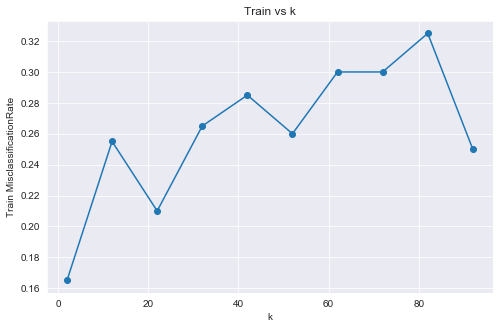

In [75]:
plotit(K,train_err,'k','Train MisclassificationRate','Train vs k')

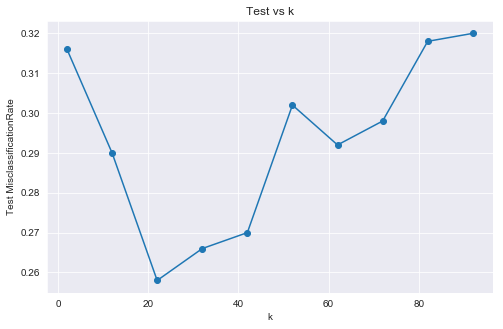

In [76]:
plotit(K,test_err,'k','Test MisclassificationRate','Test vs k')

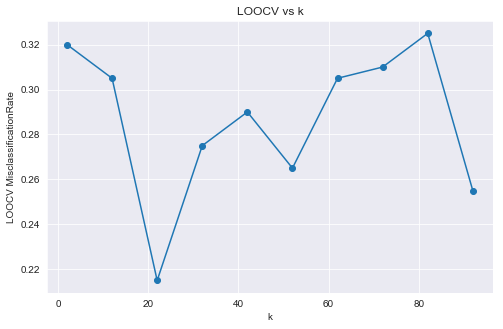

In [77]:
plotit(K,loocv_err,'k','LOOCV MisclassificationRate','LOOCV vs k')

#### (e) : Least Squares Regression with Response Variables

In [78]:
def responseClassify(d):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    N = len(Y_train)
    N0 = np.sum(Y_train == 0)
    N1 = np.sum(Y_train == 1)
    
    Yresp = [-N/N0 if y==0 else N/N1 for y in Y_train]
    alpha = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, Yresp))
    Ypred_train = np.dot(X_train, alpha)
    Ypred_test = np.dot(X_test, alpha)
    
    Ypred_train_clf = [0 if y<0 else 1 for y in Ypred_train]
    Ypred_test_clf = [0 if y<0 else 1 for y in Ypred_test]
    
    train_err = np.mean(Y_train != Ypred_train_clf)
    test_err = np.mean(Y_test != Ypred_test_clf)
    print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(round(train_err,3), round(test_err,3), d))

In [79]:
for d in [2,10,25,50]:
    responseClassify(d)

Missclasification Rate- TRAIN:0.39 | TEST:0.396 | D:2
Missclasification Rate- TRAIN:0.195 | TEST:0.316 | D:10
Missclasification Rate- TRAIN:0.17 | TEST:0.262 | D:25
Missclasification Rate- TRAIN:0.145 | TEST:0.28 | D:50


#### (f) : Logistic Discriminant Analysis

In [80]:
from sklearn.linear_model import LogisticRegression

def logClassify(d):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    clf = LogisticRegression()
    clf.fit(X_train, Y_train)
    
    train_err = 1 - clf.score(X_train, Y_train)
    test_err = 1 - clf.score(X_test, Y_test)
    print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{}'.format(round(train_err,3), round(test_err,3), d))


In [81]:
for d in [2,10,25,50]:
    logClassify(d)

Missclasification Rate- TRAIN:0.31 | TEST:0.314 | D:2
Missclasification Rate- TRAIN:0.03 | TEST:0.09 | D:10
Missclasification Rate- TRAIN:0.0 | TEST:0.038 | D:25
Missclasification Rate- TRAIN:0.0 | TEST:0.038 | D:50


#### (g) : Support Vector Machine

In [82]:
from sklearn.svm import SVC

def svmClassify(d, KERNEL):
    X_train, Y_train, X_test, Y_test, PARAMS = gen_data(d)
    clf = SVC(kernel=KERNEL, degree=2) # if poly is chosed degree=2 for quadratic
    clf.fit(X_train, Y_train)
    
    train_err = 1 - clf.score(X_train, Y_train)
    test_err = 1 - clf.score(X_test, Y_test)
    print('Missclasification Rate- TRAIN:{} | TEST:{} | D:{} | KERNEL:{}'.format(round(train_err,3), round(test_err,3), d, KERNEL))

In [83]:
for kernel in ['linear', 'poly', 'rbf']:
    for d in [2,10,25,50]:
        svmClassify(d, KERNEL=kernel)
    print('--------------------------------------------')

Missclasification Rate- TRAIN:0.495 | TEST:0.502 | D:2 | KERNEL:linear
Missclasification Rate- TRAIN:0.03 | TEST:0.098 | D:10 | KERNEL:linear
Missclasification Rate- TRAIN:0.0 | TEST:0.054 | D:25 | KERNEL:linear
Missclasification Rate- TRAIN:0.0 | TEST:0.024 | D:50 | KERNEL:linear
--------------------------------------------
Missclasification Rate- TRAIN:0.45 | TEST:0.476 | D:2 | KERNEL:poly
Missclasification Rate- TRAIN:0.0 | TEST:0.088 | D:10 | KERNEL:poly
Missclasification Rate- TRAIN:0.0 | TEST:0.032 | D:25 | KERNEL:poly
Missclasification Rate- TRAIN:0.0 | TEST:0.022 | D:50 | KERNEL:poly
--------------------------------------------
Missclasification Rate- TRAIN:0.165 | TEST:0.268 | D:2 | KERNEL:rbf
Missclasification Rate- TRAIN:0.0 | TEST:0.172 | D:10 | KERNEL:rbf
Missclasification Rate- TRAIN:0.0 | TEST:0.226 | D:25 | KERNEL:rbf
Missclasification Rate- TRAIN:0.0 | TEST:0.214 | D:50 | KERNEL:rbf
--------------------------------------------
